In [32]:
# from pathlib import Path

import os
import glob
from pathlib import Path
import numpy as np
import torch
# import cv2
import open3d as o3d
from open3d import JVisualizer
import trimesh
import matplotlib.pyplot as plt
# import scipy.signal as signal
# from tqdm import tqdm
# import multiprocessing as mp

# from neugraspnet.grasp import Grasp, Label
from neugraspnet.io import *
from neugraspnet.perception import *
from neugraspnet.simulation import ClutterRemovalSim
from neugraspnet.utils.transform import Rotation, Transform
from neugraspnet.utils.implicit import get_scene_from_mesh_pose_list, as_mesh
from neugraspnet.utils.misc import apply_noise
from neugraspnet.grasp_sampler import GpgGraspSamplerPcl
from neugraspnet.networks import get_network, load_network

np.random.seed()

constructed_root = Path("/home/sjauhri/IAS_WS/potato-net/GIGA-TSDF/GIGA-6DoF/data/3DGraspAff/data_affnet_train_constructed_GPG_60")
model_type = "neu_grasp_pn_affnet_sem"
model_path = "/home/sjauhri/IAS_WS/potato-net/GIGA-TSDF/GIGA-6DoF/data/runs_relevant_affnet/23-11-08-03-40-33_dataset=data_affnet_train_constructed_GPG_60,augment=False,net=6d_neu_grasp_pn_affnet_sem,batch_size=64,lr=2e-04,AFFNET_SEM_v4_no_hand_balanced_CONT/best_neural_grasp_neu_grasp_pn_affnet_sem_val_acc=0.9039.pt"
device = "cuda"
net = load_network(model_path, device, model_type)

previous_root="/home/sjauhri/IAS_WS/potato-net/GIGA-TSDF/GIGA-6DoF/data/3DGraspAff/data_affnet_train_random_raw_GPG_60"
data_root = "/home/sjauhri/IAS_WS/potato-net/GIGA-TSDF/GIGA-6DoF/"

sim_gui = False
three_cameras = True # Use one camera for wrist and two cameras for the fingers
add_noise = False # Add dex noise to the rendered images like GIGA
noise_type = 'mod_dex'
gp_rate = 0.5 # Rate of applying Gaussian process noise
voxel_downsample_size = 0.002 # 2mm
max_points = 1023
scene='affnet' # 'pile'
object_set='test' # 'pile/train'

## Re-create the saved simulation
# Get random scene
index = np.random.randint(32000) # index 20 is a good example.
mesh_list_files = glob.glob(os.path.join(previous_root, 'mesh_pose_list', '*.npz'))
mesh_pose_list = np.load(mesh_list_files[index], allow_pickle=True)['pc']
scene_id = os.path.basename(mesh_list_files[index])[:-4] # scene id without .npz extension
## Get specific scene
# scene_id = 'f614e39ed9df4e1094d569cddc20979b'
# mesh_list_file = os.path.join(previous_root, 'mesh_pose_list', scene_id + '.npz')
# mesh_pose_list = np.load(mesh_list_file, allow_pickle=True)['pc']

sim = ClutterRemovalSim(scene, object_set, gui=sim_gui, data_root=data_root) # parameters scene and object_set are not used
sim.setup_sim_scene_from_mesh_pose_list(mesh_pose_list, table=False, data_root=data_root) # Setting table to False because we don't want to render it
# sim.save_state()

# Get scene point cloud and normals using ground truth meshes
scene_mesh = get_scene_from_mesh_pose_list(mesh_pose_list, data_root=data_root)
o3d_scene_mesh = scene_mesh.as_open3d
o3d_scene_mesh.compute_vertex_normals()
pc = o3d_scene_mesh.sample_points_uniformly(number_of_points=1000)
points = np.asarray(pc.points)
# pc_trimesh = trimesh.points.PointCloud(points)
# pc_colors = np.array([trimesh.visual.random_color() for i in points])
# pc_trimesh.vertices_color = pc_colors
# trimesh.Scene([scene_mesh, pc_trimesh]).show()
# o3d.visualization.draw_geometries([pc])
visualizer = JVisualizer()
pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0, 0, 0]), (np.asarray(pc.points).shape[0], 1)))
visualizer.add_geometry(pc)
visualizer.show()

Loading [neu_grasp_pn_affnet_sem] model from /home/sjauhri/IAS_WS/potato-net/GIGA-TSDF/GIGA-6DoF/data/runs_relevant_affnet/23-11-08-03-40-33_dataset=data_affnet_train_constructed_GPG_60,augment=False,net=6d_neu_grasp_pn_affnet_sem,batch_size=64,lr=2e-04,AFFNET_SEM_v4_no_hand_balanced_CONT/best_neural_grasp_neu_grasp_pn_affnet_sem_val_acc=0.9039.pt


JVisualizer with 1 geometries

In [33]:
def render_side_images(sim, n=1, random=False, camera=None):
    if camera is None:
        camera = sim.camera
    height, width = camera.intrinsic.height, camera.intrinsic.width
    origin = Transform(Rotation.identity(), np.r_[sim.size / 2, sim.size / 2, sim.size / 3])

    extrinsics = np.empty((n, 7), np.float32)
    depth_imgs = np.empty((n, height, width), np.float32)

    for i in range(n):
        if random:
            r = np.random.uniform(1.6, 2.4) * sim.size
            theta = np.random.uniform(np.pi / 4.0, 5.0 * np.pi / 12.0)
            phi = np.random.uniform(- 5.0 * np.pi / 5, - 3.0 * np.pi / 8.0)
        else:
            r = 2 * sim.size
            theta = np.pi / 3.0
            phi = - np.pi / 2.0

        extrinsic = camera_on_sphere(origin, r, theta, phi)
        depth_img = camera.render(extrinsic)[1]

        extrinsics[i] = extrinsic.to_list()
        depth_imgs[i] = depth_img

    return depth_imgs, extrinsics
# Create our own camera
width, height = 64, 64 # relatively low resolution
width_fov = np.deg2rad(120.0) # angular FOV
height_fov = np.deg2rad(120.0) # angular FOV
f_x = width / (np.tan(width_fov / 2.0))
f_y = height / (np.tan(height_fov / 2.0))
intrinsic = CameraIntrinsic(width, height, f_x, f_y, width/2, height/2)

# To capture 5cms on both sides of the gripper, using a 120 deg FOV, we need to be atleast 0.05/tan(60) = 2.8 cms away
height_max_dist = sim.gripper.max_opening_width/2.5
width_max_dist  = sim.gripper.max_opening_width/2.0 + 0.015 # 1.5 cm extra
dist_from_gripper = width_max_dist/np.tan(width_fov/2.0) 
min_measured_dist = 0.001
max_measured_dist = dist_from_gripper + sim.gripper.finger_depth + 0.005 # 0.5 cm extra
camera = sim.world.add_camera(intrinsic, min_measured_dist, max_measured_dist+0.05) # adding 5cm extra for now but will filter it below
# depth_imgs_side, extrinsics_side = render_side_images(sim, 1, camera=camera)
# plt.imshow(depth_imgs_side[0]) # Normally too far away to see anything

if three_cameras:
    # Use one camera for wrist and two cameras for the fingers
    # finger_height_max_dist = sim.gripper.max_opening_width/2.5 # Not required if filtering combined cloud
    finger_width_max_dist = sim.gripper.finger_depth/2.0 + 0.005 # 0.5 cm extra
    dist_from_finger = finger_width_max_dist/np.tan(width_fov/2.0)
    finger_max_measured_dist = dist_from_finger + 0.95*sim.gripper.max_opening_width
    finger_camera  = sim.world.add_camera(intrinsic, min_measured_dist, finger_max_measured_dist+0.05) # adding 5cm extra for now but will filter it below

In [34]:
# sample grasps with GPG:
sampler = GpgGraspSamplerPcl(sim.gripper.finger_depth-0.0075) # Franka finger depth is actually a little less than 0.05
safety_dist_above_table = sim.gripper.finger_depth # table is spawned at finger_depth
grasps, grasps_pos, grasps_rot = sampler.sample_grasps(pc, num_grasps=1, max_num_samples=180,
                                    safety_dis_above_table=safety_dist_above_table, show_final_grasps=False)

In [35]:
# Viz grasps
grasps_scene = trimesh.Scene()
from neugraspnet.utils import visual
grasp_mesh_list = [visual.grasp2mesh(g) for g in grasps]
for i, g_mesh in enumerate(grasp_mesh_list):
    grasps_scene.add_geometry(g_mesh, node_name=f'grasp_{i}')
    break
# grasps_scene.show()
composed_scene = trimesh.Scene([scene_mesh, grasps_scene])
composed_scene.show()
# visualizer.add_geometry(as_mesh(grasps_scene).as_open3d)
# o3d.visualization.draw_geometries([pc, as_mesh(grasps_scene).as_open3d])

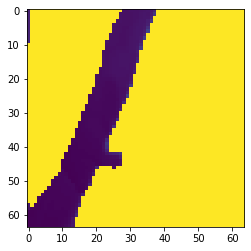

In [36]:
## Move camera to grasp offset frame
grasp_center = grasps[0].pose.translation
# Unfortunately VGN/GIGA grasps are not in the grasp frame we want (frame similar to PointNetGPD), so we need to transform them
grasp_frame_rot =  grasps[0].pose.rotation * Rotation.from_euler('Y', np.pi/2) * Rotation.from_euler('Z', np.pi)
grasp_tf = Transform(grasp_frame_rot, grasp_center).as_matrix()
offset_pos =  (grasp_tf @ np.array([[-dist_from_gripper],[0],[0],[1.]]))[:3].squeeze() # Move to offset frame
# (Debug) viz the grasp center and offset_pos:
# visualizer.add_geometry(o3d.geometry.PointCloud(o3d.utility.Vector3dVector(grasp_center.reshape(1,3))))
# visualizer.add_geometry(o3d.geometry.PointCloud(o3d.utility.Vector3dVector(offset_pos.reshape(1,3))))
# visualizer.show()

# Unfortunately the bullet renderer uses the OpenGL format so we have to use yet another extrinsic
grasp_up_axis = grasp_tf.T[2,:3] # np.array([0.0, 0.0, 1.0]) # grasp_tf z-axis
extrinsic_bullet = Transform.look_at(eye=offset_pos, center=grasp_center, up=grasp_up_axis)

## render image
depth_img = camera.render(extrinsic_bullet)[1]
# Optional: Add some dex noise like GIGA
if add_noise:
    depth_img = apply_noise(depth_img, noise_type=noise_type, gp_rate=gp_rate)
plt.imshow(depth_img)


In [37]:
## Do the same for the other cameras
if three_cameras:
    ## Move camera to finger offset frame
    fingers_center =  (grasp_tf @ np.array([[sim.gripper.finger_depth/2.0],[0],[0],[1.]]))[:3].squeeze()
    left_finger_offset_pos  =  (grasp_tf @ np.array([[sim.gripper.finger_depth/2.0],[ (dist_from_finger + sim.gripper.max_opening_width/2.0)],[0],[1.]]))[:3].squeeze()
    right_finger_offset_pos =  (grasp_tf @ np.array([[sim.gripper.finger_depth/2.0],[-(dist_from_finger + sim.gripper.max_opening_width/2.0)],[0],[1.]]))[:3].squeeze()
    
    # Unfortunately the bullet renderer uses the OpenGL format so we have to use yet another extrinsic
    left_finger_extrinsic_bullet  = Transform.look_at(eye=left_finger_offset_pos,  center=fingers_center, up=grasp_up_axis)
    right_finger_extrinsic_bullet = Transform.look_at(eye=right_finger_offset_pos, center=fingers_center, up=grasp_up_axis)

    ## render image
    left_finger_depth_img  = finger_camera.render(left_finger_extrinsic_bullet )[1]
    right_finger_depth_img = finger_camera.render(right_finger_extrinsic_bullet)[1]
    # Optional: Add some dex noise like GIGA
    if add_noise:
        left_finger_depth_img = apply_noise(left_finger_depth_img, noise_type=noise_type, gp_rate=gp_rate)
        right_finger_depth_img = apply_noise(right_finger_depth_img, noise_type=noise_type, gp_rate=gp_rate)
    # Viz
    # plt.imshow(left_finger_depth_img)
    # plt.imshow(right_finger_depth_img)

In [38]:
# ## Convert to point cloud (TODO: Do this yourself with filtering)
# camera_mat_o3d = o3d.camera.PinholeCameraIntrinsic(128, 128, intrinsic.K[0,0], intrinsic.K[1,1], intrinsic.K[0,2], intrinsic.K[1,2])
# grasp_cam_local_depth_pc = o3d.geometry.PointCloud.create_from_depth_image(o3d.geometry.Image(depth_img), camera_mat_o3d, extrinsic_bullet.as_matrix(), depth_scale=1.0)
# # grasp_cam_local_depth_pc = o3d.geometry.PointCloud.create_from_depth_image(o3d.geometry.Image(depth_img), camera_mat_o3d, depth_scale=1.0)


# ## Viz point cloud and grasp
# grasp_cam_local_depth_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0, 0, 1]), (np.asarray(grasp_cam_local_depth_pc.points).shape[0], 1)))
# visualizer = JVisualizer()
# visualizer.add_geometry(grasp_cam_local_depth_pc)

# if three_cameras:
#     left_cam_local_depth_pc  = o3d.geometry.PointCloud.create_from_depth_image(o3d.geometry.Image(left_finger_depth_img),  camera_mat_o3d, left_finger_extrinsic_bullet.as_matrix(),  depth_scale=1.0)
#     right_cam_local_depth_pc = o3d.geometry.PointCloud.create_from_depth_image(o3d.geometry.Image(right_finger_depth_img), camera_mat_o3d, right_finger_extrinsic_bullet.as_matrix(), depth_scale=1.0)
#     left_cam_local_depth_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([1, 0, 0]), (np.asarray(left_cam_local_depth_pc.points).shape[0], 1)))
#     right_cam_local_depth_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0, 1, 0]), (np.asarray(right_cam_local_depth_pc.points).shape[0], 1)))
#     visualizer.add_geometry(left_cam_local_depth_pc)
#     visualizer.add_geometry(right_cam_local_depth_pc)

# visualizer.show()

In [39]:
## Convert to point cloud
pixel_grid = np.meshgrid(np.arange(width), np.arange(height))
pixels = np.dstack((pixel_grid[0],pixel_grid[1])).reshape(-1, 2)

# depth_eps = 0.0001
depth_array = depth_img.reshape(-1)
relevant_mask = depth_array < (max_measured_dist) #- depth_eps) # only depth values in range

filt_pixels = np.array(pixels[relevant_mask]) # only consider pixels with depth values in range
filt_pixels = np.hstack((filt_pixels, np.ones((filt_pixels.shape[0], 2)))) # Homogenous co-ordinates
# Project pixels into camera space
filt_pixels[:,:3] *= depth_array[relevant_mask].reshape(-1, 1) # Multiply by depth
intrinsic_hom = np.eye(4)
intrinsic_hom[:3,:3] = intrinsic.K
p_local = np.linalg.inv(intrinsic_hom) @ filt_pixels.T
# Also filter out points that are more than max dist height # Not required if filtering combined cloud
# p_local = p_local[:, p_local[1,:] <  height_max_dist]
# p_local = p_local[:, p_local[1,:] > -height_max_dist]
p_world = np.linalg.inv(extrinsic_bullet.as_matrix()) @ p_local

## Viz point cloud and grasp
# grasp_cam_local_depth_pc = o3d.geometry.PointCloud()
# grasp_cam_local_depth_pc.points = o3d.utility.Vector3dVector(p_local[:3,:].T)
grasp_cam_world_depth_pc = o3d.geometry.PointCloud()
grasp_cam_world_depth_pc.points = o3d.utility.Vector3dVector(p_world[:3,:].T)
# grasp_cam_local_depth_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0, 1, 1]), (np.asarray(grasp_cam_local_depth_pc.points).shape[0], 1)))
grasp_cam_world_depth_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0, 0, 1]), (np.asarray(grasp_cam_world_depth_pc.points).shape[0], 1)))
# visualizer = JVisualizer()
# visualizer.add_geometry(grasp_cam_local_depth_pc)
visualizer.add_geometry(grasp_cam_world_depth_pc)
# viz original pc and gripper
o3d_gripper_mesh = as_mesh(grasps_scene).as_open3d
gripper_pc = o3d_gripper_mesh.sample_points_uniformly(number_of_points=30000)
gripper_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([1, 1, 0]), (np.asarray(gripper_pc.points).shape[0], 1)))
visualizer.add_geometry(gripper_pc)

if three_cameras:
    left_finger_depth_array = left_finger_depth_img.reshape(-1)
    left_relevant_mask = left_finger_depth_array < (finger_max_measured_dist)# - depth_eps) # only depth values in range
    left_filt_pixels = np.array(pixels[left_relevant_mask]) # only consider pixels with depth values in range
    
    left_filt_pixels = np.hstack((left_filt_pixels, np.ones((left_filt_pixels.shape[0], 2)))) # Homogenous co-ordinates
    # Project pixels into camera space
    left_filt_pixels[:,:3] *= left_finger_depth_array[left_relevant_mask].reshape(-1, 1) # Multiply by depth
    left_p_local = np.linalg.inv(intrinsic_hom) @ left_filt_pixels.T
    # Also filter out points that are more than max dist height and width # Not required if filtering combined cloud
    # left_p_local = left_p_local[:, left_p_local[0,:] <  finger_width_max_dist]
    # left_p_local = left_p_local[:, left_p_local[0,:] > -finger_width_max_dist]
    # left_p_local = left_p_local[:, left_p_local[1,:] <  finger_height_max_dist]
    # left_p_local = left_p_local[:, left_p_local[1,:] > -finger_height_max_dist]
    left_p_world = np.linalg.inv(left_finger_extrinsic_bullet.as_matrix()) @ left_p_local

    right_finger_depth_array = right_finger_depth_img.reshape(-1)
    right_relevant_mask = right_finger_depth_array < (finger_max_measured_dist)# - depth_eps) # only depth values in range
    right_filt_pixels = np.array(pixels[right_relevant_mask]) # only consider pixels with depth values in range
    
    right_filt_pixels = np.hstack((right_filt_pixels, np.ones((right_filt_pixels.shape[0], 2)))) # Homogenous co-ordinates
    # Project pixels into camera space
    right_filt_pixels[:,:3] *= right_finger_depth_array[right_relevant_mask].reshape(-1, 1) # Multiply by depth
    right_p_local = np.linalg.inv(intrinsic_hom) @ right_filt_pixels.T
    # Also filter out points that are more than max dist height and width # Not required if filtering combined cloud
    # right_p_local = right_p_local[:, right_p_local[0,:] <  finger_width_max_dist]
    # right_p_local = right_p_local[:, right_p_local[0,:] > -finger_width_max_dist]
    # right_p_local = right_p_local[:, right_p_local[1,:] <  finger_height_max_dist]
    # right_p_local = right_p_local[:, right_p_local[1,:] > -finger_height_max_dist]
    right_p_world = np.linalg.inv(right_finger_extrinsic_bullet.as_matrix()) @ right_p_local    

    # Viz
    left_cam_world_depth_pc = o3d.geometry.PointCloud()
    left_cam_world_depth_pc.points = o3d.utility.Vector3dVector(left_p_world[:3,:].T)
    right_cam_world_depth_pc = o3d.geometry.PointCloud()
    right_cam_world_depth_pc.points = o3d.utility.Vector3dVector(right_p_world[:3,:].T)

    left_cam_world_depth_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([1, 0, 0]), (np.asarray(left_cam_world_depth_pc.points).shape[0], 1)))
    right_cam_world_depth_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0, 1, 0]), (np.asarray(right_cam_world_depth_pc.points).shape[0], 1)))
    visualizer.add_geometry(left_cam_world_depth_pc)
    visualizer.add_geometry(right_cam_world_depth_pc)

visualizer.show()

JVisualizer with 5 geometries

In [40]:
# Combine and downsample surface point cloud
combined_world_points = np.hstack((p_world, left_p_world, right_p_world))
# filter points
combined_world_points_local = np.linalg.inv(grasp_tf) @ combined_world_points
inval_mask = combined_world_points_local[0,:] > (max_measured_dist - dist_from_gripper) # too far X
inval_mask = inval_mask | (combined_world_points_local[0,:] < -dist_from_gripper)       # too close X
inval_mask = inval_mask | (combined_world_points_local[2,:] >  height_max_dist)         # too far Z
inval_mask = inval_mask | (combined_world_points_local[2,:] < -height_max_dist)         # too close Z
combined_world_points_filt = combined_world_points[:, ~inval_mask]

combined_pc = o3d.geometry.PointCloud()
combined_pc.points = o3d.utility.Vector3dVector(combined_world_points_filt[:3,:].T)

down_combined_pc = combined_pc.voxel_down_sample(voxel_size=voxel_downsample_size)
# If more than max points, uniformly sample
if len(down_combined_pc.points) > max_points:
    indices = np.random.choice(np.arange(len(down_combined_pc.points)), max_points, replace=False)
    down_combined_pc = down_combined_pc.select_by_index(indices)
down_combined_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([1.0, 0.45, 0.]), (np.asarray(down_combined_pc.points).shape[0], 1)))
visualizer2 = JVisualizer()
visualizer2.add_geometry(down_combined_pc)
# viz original pc and gripper
visualizer2.add_geometry(pc)
visualizer2.add_geometry(gripper_pc)
visualizer2.show()
down_combined_pc

JVisualizer with 3 geometries

PointCloud with 701 points.

In [41]:
## render grasp cloud with implicit geometry function:

batch_size = 1
n_steps = 50
n_pts = width*height*3

# load input tsdf
tsdf = read_voxel_grid(constructed_root, scene_id)

# Generate proposal points
def get_sphere_intersection(cam_loc, ray_directions, r = 1.0):
    # Input: n_images x 4 x 4 ; n_images x n_rays x 3
    # Output: n_images * n_rays x 2 (close and far) ; n_images * n_rays

    n_imgs, n_pix, _ = ray_directions.shape
    cam_loc = cam_loc.unsqueeze(-1)
    
    ray_cam_dot = torch.bmm(ray_directions, cam_loc).squeeze()
    under_sqrt = ray_cam_dot ** 2 - (cam_loc.norm(2,1) ** 2 - r ** 2)

    under_sqrt = under_sqrt.reshape(-1)
    mask_intersect = under_sqrt > 0
    
    sphere_intersections = torch.zeros(n_imgs * n_pix, 2).float()
    sphere_intersections[mask_intersect] = torch.sqrt(under_sqrt[mask_intersect]).unsqueeze(-1) * torch.Tensor([-1, 1]).float()
    sphere_intersections[mask_intersect] -= ray_cam_dot.reshape(-1)[mask_intersect].unsqueeze(-1)

    sphere_intersections = sphere_intersections.reshape(n_imgs, n_pix, 2)
    sphere_intersections = sphere_intersections.clamp_min(0.0)
    mask_intersect = mask_intersect.reshape(n_imgs, n_pix)

    return sphere_intersections, mask_intersect

def get_proposal(ray0, ray_direction, n_steps=256, depth_range=[0.01, 2.0], rad=0.5):

    # Beyond the 30cm box everything is blank/white
    depth_intersect, _ = get_sphere_intersection(ray0[:,0], ray_direction, r=rad)
    d_intersect = depth_intersect[...,1]            
    
    d_proposal = torch.linspace(0, 1, steps=n_steps).view(1, 1, n_steps, 1)
    d_proposal = depth_range[0] * (1. - d_proposal) + d_intersect.view(1, -1, 1, 1)* d_proposal

    #print(d_proposal.size(), ray0.size(), ray_direction.size())

    p_proposal = ray0.unsqueeze(2).repeat(1, 1, n_steps, 1) + ray_direction.unsqueeze(2).repeat(1, 1, n_steps, 1) * d_proposal

    return p_proposal, d_proposal, depth_intersect[...,0]

def get_simple_proposal(ray0, ray_direction, n_steps=256, depth_range=[0.001, 0.18]):
    
    d_proposal = torch.linspace(0, 1, steps=n_steps).view(1, 1, n_steps, 1)
    d_proposal = depth_range[0] * (1. - d_proposal) + depth_range[1]* d_proposal

    p_proposal = ray0.unsqueeze(2).repeat(1, 1, n_steps, 1) + ray_direction.unsqueeze(2).repeat(1, 1, n_steps, 1) * d_proposal

    return p_proposal, d_proposal

# Make pixel points
pixel_grid = torch.meshgrid(torch.arange(width), torch.arange(height))
pixels = torch.dstack((pixel_grid[0],pixel_grid[1])).reshape(-1, 2)
# pixels = torch.cartesian_prod(torch.arange(width), torch.arange(height))
pixels_hom = torch.hstack((pixels, torch.ones((pixels.shape[0], 2)))) # Homogenous co-ordinates
camera_world = torch.tensor(extrinsic_bullet.inverse().translation).repeat(pixels.shape[0],1).unsqueeze(0)
left_camera_world = torch.tensor(left_finger_extrinsic_bullet.inverse().translation).repeat(pixels.shape[0],1).unsqueeze(0)
right_camera_world = torch.tensor(right_finger_extrinsic_bullet.inverse().translation).repeat(pixels.shape[0],1).unsqueeze(0)

# Convert pixel points to world co-ords:
intrinsic_hom = torch.eye(4)
intrinsic_hom[:3,:3] = torch.tensor(intrinsic.K)
image_plane_depth = 0.001 # 1mm
pixels_hom[:,:3] *= image_plane_depth # Multiply by depth
pixels_local_hom = torch.inverse(intrinsic_hom) @ pixels_hom.T
pixels_world = torch.inverse(torch.tensor(extrinsic_bullet.as_matrix()).float()) @ pixels_local_hom
# Add batch_size dimension
pixels_local = pixels_local_hom[:3,:].T.unsqueeze(0).float()
origin = torch.zeros(pixels.shape[0],3).unsqueeze(0)
ray_vector_local = (pixels_local - origin)
ray_vector_local = ray_vector_local/ray_vector_local.norm(2,2).unsqueeze(-1)

pixels_world = pixels_world[:3,:].T.unsqueeze(0).float()
ray_vector_world = (pixels_world - camera_world)
ray_vector_world = ray_vector_world/ray_vector_world.norm(2,2).unsqueeze(-1)

p_proposal_world, d_proposal = get_simple_proposal(camera_world,
                                                ray_vector_world,
                                                n_steps=n_steps,
                                                depth_range=[min_measured_dist, max_measured_dist*1.5])
left_pixels_world =  torch.inverse(torch.tensor(left_finger_extrinsic_bullet.as_matrix()).float()) @ pixels_local_hom
left_pixels_world = left_pixels_world[:3,:].T.unsqueeze(0).float()
left_ray_vector_world = (left_pixels_world - left_camera_world)
left_ray_vector_world = left_ray_vector_world/left_ray_vector_world.norm(2,2).unsqueeze(-1)
left_p_proposal_world, left_d_proposal = get_simple_proposal(left_camera_world,
                                                left_ray_vector_world,
                                                n_steps=n_steps,
                                                depth_range=[min_measured_dist, finger_max_measured_dist*1.1])
right_pixels_world =  torch.inverse(torch.tensor(right_finger_extrinsic_bullet.as_matrix()).float()) @ pixels_local_hom
right_pixels_world = right_pixels_world[:3,:].T.unsqueeze(0).float()
right_ray_vector_world = (right_pixels_world - right_camera_world)
right_ray_vector_world = right_ray_vector_world/right_ray_vector_world.norm(2,2).unsqueeze(-1)
right_p_proposal_world, right_d_proposal = get_simple_proposal(right_camera_world,
                                                right_ray_vector_world,
                                                n_steps=n_steps,
                                                depth_range=[min_measured_dist, finger_max_measured_dist*1.1])
## p_loc_proposal_combined = p_loc_proposal.reshape(-1,3)
## p_loc_proposal_hom = torch.hstack((p_loc_proposal_combined, torch.ones((p_loc_proposal_combined.shape[0],1)))) # Homogenous co-ordinates
## p_proposal_world = torch.inverse(torch.tensor(extrinsic_bullet.as_matrix()).float()) @ p_loc_proposal_hom.T.float()

### Debug
## n_rays_plot = (width*height*3)
## index = np.random.choice(p_proposal_world.shape[1], n_rays_plot, replace=False)
## p_prop = p_proposal_world[:,index]
## visualize_plotly([tsdf, pc, p_prop.view(-1, 3), pixels_world.view(-1, 3), cam_position.reshape(1, 3)])

## Debug
# cam_pc = o3d.geometry.PointCloud()
# cam_pc.points = o3d.utility.Vector3dVector(p_proposal_world.view(-1,3))
# cam_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0.0, 0.0, 1]), (np.asarray(cam_pc.points).shape[0], 1)))
# left_cam_pc = o3d.geometry.PointCloud()
# left_cam_pc.points = o3d.utility.Vector3dVector(left_p_proposal_world.view(-1,3))
# left_cam_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([1, 0, 0]), (np.asarray(left_cam_pc.points).shape[0], 1)))
# right_cam_pc = o3d.geometry.PointCloud()
# right_cam_pc.points = o3d.utility.Vector3dVector(right_p_proposal_world.view(-1,3))
# right_cam_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0.0, 1.0, 0]), (np.asarray(right_cam_pc.points).shape[0], 1)))
# visualizer3 = JVisualizer()
# visualizer3.add_geometry(cam_pc)
# visualizer3.add_geometry(left_cam_pc)
# visualizer3.add_geometry(right_cam_pc)
# visualizer3.add_geometry(gripper_pc)
# visualizer3.show()

In [42]:
## Query network

# Normalize and shift for a 30cm cube
p_proposal_world_combined = torch.cat((p_proposal_world, left_p_proposal_world, right_p_proposal_world), dim=1)
p_scaled_proposal_query = ((p_proposal_world_combined)/0.3 - 0.5).view(batch_size,-1, 3)

# Call ConvOccNet
with torch.no_grad():
    val = net.infer_occ(torch.tensor(p_scaled_proposal_query, device=device, dtype=torch.float32), torch.tensor(tsdf, device=device, dtype=torch.float32))
val = val.cpu()
val = (val - 0.5)
num_ = torch.sum(torch.sum(val>0))
print(f"{num_} positives exist" if num_ else "All negative")
points_occ = p_proposal_world_combined.view(-1, 3)[val.squeeze()>0]

# (Optional) get semantics of surface points too!
with torch.no_grad():
    sem_val = net.infer_sem(torch.tensor(p_scaled_proposal_query, device=device, dtype=torch.float32), torch.tensor(tsdf, device=device, dtype=torch.float32))
sem_val = sem_val.cpu()
sem_val = sem_val[val.squeeze()>0]

<ipython-input-42-44f249e22bb9>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val = net.infer_occ(torch.tensor(p_scaled_proposal_query, device=device, dtype=torch.float32), torch.tensor(tsdf, device=device, dtype=torch.float32))


15148 positives exist


<ipython-input-42-44f249e22bb9>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sem_val = net.infer_sem(torch.tensor(p_scaled_proposal_query, device=device, dtype=torch.float32), torch.tensor(tsdf, device=device, dtype=torch.float32))


In [43]:
# Debug
occ_pc = o3d.geometry.PointCloud()
occ_pc.points = o3d.utility.Vector3dVector(points_occ)
occ_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0.6, 0.0, 1]), (np.asarray(occ_pc.points).shape[0], 1)))
visualizer4 = JVisualizer()
visualizer4.add_geometry(occ_pc)
visualizer4.add_geometry(gripper_pc)
visualizer4.show()

JVisualizer with 2 geometries

In [44]:
## Surface rendering
val = val.reshape(batch_size, -1, n_steps)
mask_0_not_occupied = val[:, :, 0] < 0
sign_matrix = torch.cat([torch.sign(val[:, :, :-1] * val[:, :, 1:]),
                                 torch.ones(batch_size, n_pts, 1)],
                                dim=-1)
cost_matrix = sign_matrix * torch.arange(n_steps, 0, -1).float()
values, indices = torch.min(cost_matrix, -1)
mask_sign_change = values < 0
mask_neg_to_pos = val[torch.arange(batch_size).unsqueeze(-1),torch.arange(n_pts).unsqueeze(-0), indices] < 0
mask = mask_sign_change & mask_neg_to_pos & mask_0_not_occupied


def secant(net, tsdf, f_low, f_high, d_low, d_high, n_secant_steps,
                          ray0_masked, ray_direction_masked, tau):
    ''' Runs the secant method for interval [d_low, d_high].

    Args:
        d_low (tensor): start values for the interval
        d_high (tensor): end values for the interval
        n_secant_steps (int): number of steps
        ray0_masked (tensor): masked ray start points
        ray_direction_masked (tensor): masked ray direction vectors
        model (nn.Module): model model to evaluate point occupancies
        c (tensor): latent conditioned code c
        tau (float): threshold value in logits
    '''
    d_pred = - f_low * (d_high - d_low) / (f_high - f_low) + d_low
    for i in range(n_secant_steps):
        p_mid = ray0_masked + d_pred.unsqueeze(-1) * ray_direction_masked
        p_scaled_mid = (p_mid/0.3 - 0.5).to(tsdf.device).float()
        with torch.no_grad():
            f_mid = (net.infer_occ(p_scaled_mid.view(1, -1, 3),  tsdf)- tau).squeeze()#.cpu()
        ind_low = f_mid < 0
        ind_low = ind_low
        if ind_low.sum() > 0:
            d_low[ind_low] = d_pred[ind_low]
            f_low[ind_low] = f_mid[ind_low]
        if (ind_low == 0).sum() > 0:
            d_high[ind_low == 0] = d_pred[ind_low == 0]
            f_high[ind_low == 0] = f_mid[ind_low == 0]

        d_pred = - f_low * (d_high - d_low) / (f_high - f_low) + d_low
    return d_pred

n = batch_size * n_pts
d_proposal = d_proposal.repeat(1,int(n_pts/3),1,1)
left_d_proposal = left_d_proposal.repeat(1,int(n_pts/3),1,1)
right_d_proposal = right_d_proposal.repeat(1,int(n_pts/3),1,1)
d_proposal = torch.cat((d_proposal, left_d_proposal, right_d_proposal), dim=1) # combine for all cameras
d_low = d_proposal.view(n, n_steps, 1)[torch.arange(n), indices.view(n)].view(batch_size, n_pts)[mask]
f_low = val.view(n, n_steps, 1)[torch.arange(n), indices.view(n)].view(
            batch_size, n_pts)[mask]
indices = torch.clamp(indices + 1, max=n_steps-1)
d_high = d_proposal.view(n, n_steps, 1)[torch.arange(n), indices.view(n)].view(batch_size, n_pts)[mask]
f_high = val.view(n, n_steps, 1)[torch.arange(n), indices.view(n)].view(batch_size, n_pts)[mask]

ray0_masked = torch.cat((camera_world, left_camera_world, right_camera_world), dim=1)[mask]
ray_direction_masked = torch.cat((ray_vector_world, left_ray_vector_world, right_ray_vector_world), dim=1)[mask]

# Apply surface depth refinement step (e.g. Secant method)
n_secant_steps = 8
with torch.no_grad():
    d_pred = secant(net, torch.tensor(tsdf, device=device),
        f_low.cuda(), f_high.cuda(), d_low.cuda(), d_high.cuda(), n_secant_steps, ray0_masked.cuda(),
        ray_direction_masked.cuda(), tau=torch.tensor(0.5, device=device))
d_pred = d_pred.cpu()

In [45]:
# Project depth to 3d poinsts
# t_nan = torch.tensor(float('nan'))
points_out = torch.zeros(batch_size, n_pts, 3, dtype=torch.double)#*t_nan # set default (invalid) values
points_out[mask] = ray0_masked + ray_direction_masked * d_pred.unsqueeze(1)

# Filter points too far away from the gripper
# transform world points to grasp frame
points_out_hom = torch.cat((points_out, torch.ones(batch_size, n_pts, 1)), dim=-1)
grasps_inv_tf = torch.tensor(grasp_tf).inverse().repeat(batch_size, 1, 1)
points_out_local = torch.bmm(grasps_inv_tf, points_out_hom.transpose(1,2))

inval_mask = points_out_local[:,0,:] > (max_measured_dist - dist_from_gripper) # too far X
inval_mask = inval_mask | (points_out_local[:,0,:] < -dist_from_gripper)       # too close X
inval_mask = inval_mask | (points_out_local[:,2,:] >  height_max_dist)         # too far Z
inval_mask = inval_mask | (points_out_local[:,2,:] < -height_max_dist)         # too close Z

surf_mask = mask & ~inval_mask

In [46]:
surface_points_out_0 = points_out[0, surf_mask[0]]

# Debug
surf_pc = o3d.geometry.PointCloud()
surf_pc.points = o3d.utility.Vector3dVector(surface_points_out_0)
down_surf_pc = surf_pc
down_surf_pc = surf_pc.voxel_down_sample(voxel_size=voxel_downsample_size)
# If more than max points, uniformly sample
if len(down_surf_pc.points) > max_points:
    indices = np.random.choice(np.arange(len(down_surf_pc.points)), max_points, replace=False)
    down_surf_pc = down_surf_pc.select_by_index(indices)
down_surf_pc.colors = o3d.utility.Vector3dVector(np.tile(np.array([0.6, 0.0, 1]), (np.asarray(down_surf_pc.points).shape[0], 1)))
visualizer6 = JVisualizer()
visualizer6.add_geometry(down_surf_pc)
visualizer6.add_geometry(gripper_pc)
visualizer6.add_geometry(pc)
visualizer6.show()
visualizer2.show()
down_surf_pc

JVisualizer with 3 geometries

JVisualizer with 3 geometries

PointCloud with 728 points.